In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [3]:
def load_str_calls(str_path: str, segdup_ids: pd.Series = None) -> pd.DataFrame:
    df_strs = pd.read_csv(str_path)
    if segdup_ids:
        df_strs = df_strs[~df_strs["str_id"].isin(segdup_ids)].reset_index(drop=True)
    return df_strs
        


In [6]:
df_in_segdup = pd.read_csv("../../data/hg38_ver13_0boe_mononucleotides_in_segdup.bed", sep="\t", names=["chr", "start", "end", "period", "unit"])
df_in_segdup = df_in_segdup.assign(str_id = lambda x: [f"{i}_{j + 1}" for i, j in zip(x["chr"], x["start"])])

df_constrain = load_str_calls("../../results/HG002/2024-04-07_hg002_ConSTRain0.7.0.csv").rename(columns={"match": "constrain_match"})
df_gangstr = load_str_calls("../../results/HG002/2024-03-19_hg002_str_length_calls_gangstr.csv").rename(columns={"match": "gangstr_match"}).drop(["haplo_region_len", "softmatch"], axis=1).drop(["haplo_region_len", "softmatch"], axis=1)
df_hipstr = load_str_calls("../../results/HG002/2024-07-09_hg002_str_length_calls_hipstr.csv").rename(columns={"match": "hipstr_match"}).drop(["haplo_region_len", "depth", "copy_number", "period"], axis=1)

print(df_constrain.shape, df_gangstr.shape, df_hipstr.shape)

(1671143, 7) (1654569, 5) (1225530, 7)


In [19]:
df_str_calls = df_constrain.merge(df_gangstr, on="str_id", how="inner").merge(df_hipstr, on="str_id", how="inner")
df_str_calls

,str_id,haplo_region_len,estimated_region_len,constrain_match,copy_number,depth,period,gangstr_region_len,gangstr_match,hipstr_region_len,hipstr_match
0,chr1_588068,"[12, 12]","[12, 12]",True,2,22,3,"[12, 12]",True,"[12, 12]",True
1,chr1_590659,"[12, 12]","[12, 12]",True,2,60,4,"[12, 12]",True,"[12, 12]",True
2,chr1_590969,"[16, 16]","[16, 16]",True,2,42,4,"[16, 16]",True,"[16, 16]",True
3,chr1_594083,"[12, 12]","[12, 12]",True,2,21,3,"[12, 12]",True,"[12, 12]",True
4,chr1_597686,"[14, 14]","[14, 14]",True,2,40,1,"[14, 14]",True,"[14, 14]",True
...,...,...,...,...,...,...,...,...,...,...,...
1221039,chrY_26622472,[10],[10],True,1,28,5,[10],True,[10],True
1221040,chrY_26627699,[12],[12],True,1,23,3,[12],True,[12],True
1221041,chrY_26628607,[15],[15],True,1,31,5,[15],True,[15],True
1221042,chrY_26635262,[10],[10],True,1,33,1,[10],True,[10],True


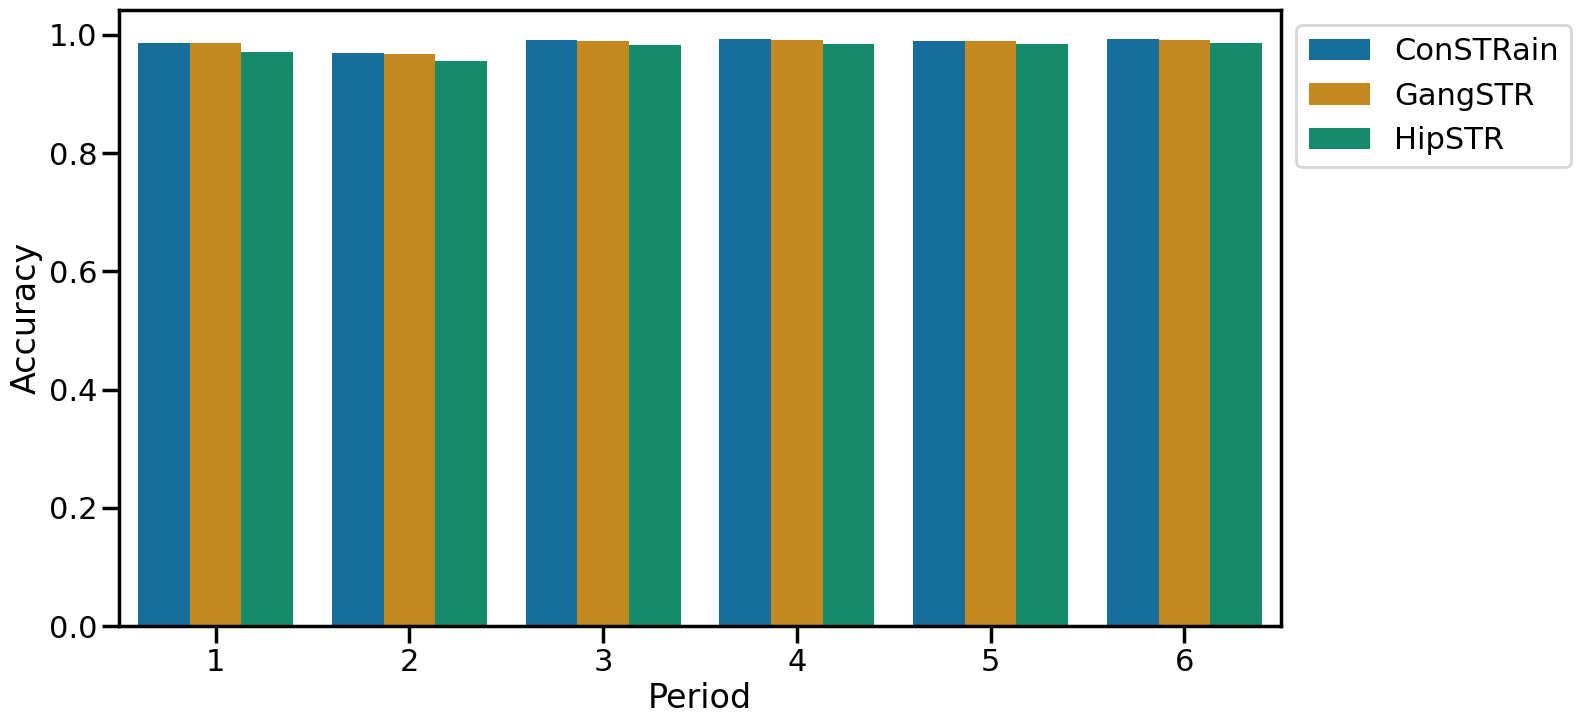

In [20]:
df_overview = (df_str_calls[["period", "constrain_match", "gangstr_match", "hipstr_match"]]
               .groupby("period", as_index=False)
               .agg(ConSTRain = ("constrain_match", lambda x: x.sum() / len(x)), 
                    GangSTR = ("gangstr_match", lambda x: x.sum() / len(x)),
                    HipSTR = ("hipstr_match", lambda x: x.sum() / len(x)),)
               .melt(id_vars="period", var_name="approach", value_name="accuracy"))

fig = plt.figure(figsize=(15, 8))

ax = sns.barplot(
    data=df_overview,
    x="period",
    y="accuracy",
    hue="approach",
    palette="colorblind",
)

ax.set(
    xlabel="Period",
    # xlim=(None, 6),
    ylabel="Accuracy",    
)
ax.get_legend().set(bbox_to_anchor=(1,1), title="")

plt.show()

In [21]:
df_plot = pd.DataFrame(
    np.concatenate([np.repeat([1, 2, 3, 4, 5, 6], 7).reshape(-1, 1), np.tile([1, 5, 5, 10, 10, 15, 15, 20, 20, 25, 25, 30, 30, 1e6], 6).reshape(-1, 2)], axis=1),
    columns=["period", "depth_lower", "depth_upper"]
)

constrain_accuracy = []
gangstr_accuracy = []
hipstr_accuracy = []
n = []
for row in df_plot.to_dict(orient="records"):
    selected_loci = (
        df_str_calls
            .assign(depth = lambda x: x["depth"] / x["copy_number"])
            .query(f"depth >= {row['depth_lower']} and depth < {row['depth_upper']} and period == {row['period']}")["str_id"]
    )
    df_str_calls_filt = df_str_calls.loc[df_str_calls["str_id"].isin(selected_loci)]
    n.append(df_str_calls_filt.shape[0])
    constrain_accuracy.append((1 - (df_str_calls_filt.loc[~df_str_calls_filt["constrain_match"]].shape[0] / df_str_calls_filt.shape[0])) * 100)
    gangstr_accuracy.append((1 - (df_str_calls_filt.loc[~df_str_calls_filt["gangstr_match"]].shape[0] / df_str_calls_filt.shape[0])) * 100)
    hipstr_accuracy.append((1 - (df_str_calls_filt.loc[~df_str_calls_filt["hipstr_match"]].shape[0] / df_str_calls_filt.shape[0])) * 100)

df_plot["n"] = n
df_plot["constrain_accuracy"] = constrain_accuracy
df_plot["gangstr_accuracy"] = gangstr_accuracy
df_plot["hipstr_accuracy"] = hipstr_accuracy
df_plot["depth"] = np.tile(["1-5", "5-10", "10-15", "15-20", "20-25", "25-30", "30-"], 6)

df_plot

,period,depth_lower,depth_upper,n,constrain_accuracy,gangstr_accuracy,hipstr_accuracy,depth
0,1.0,1.0,5.0,1711,68.790181,69.666861,60.374050,1-5
1,1.0,5.0,10.0,5145,83.731778,88.163265,79.008746,5-10
2,1.0,10.0,15.0,12405,89.963724,93.188231,87.730754,10-15
3,1.0,15.0,20.0,28954,95.454859,96.715480,93.299717,15-20
4,1.0,20.0,25.0,69069,98.485572,98.683925,96.764105,20-25
5,1.0,25.0,30.0,124177,99.294555,99.147990,97.855480,25-30
6,1.0,30.0,1000000.0,249696,99.510204,99.286332,98.385637,30-
7,2.0,1.0,5.0,171,47.953216,46.783626,68.421053,1-5
8,2.0,5.0,10.0,566,66.607774,68.374558,69.434629,5-10
9,2.0,10.0,15.0,2388,76.968174,78.894472,79.522613,10-15


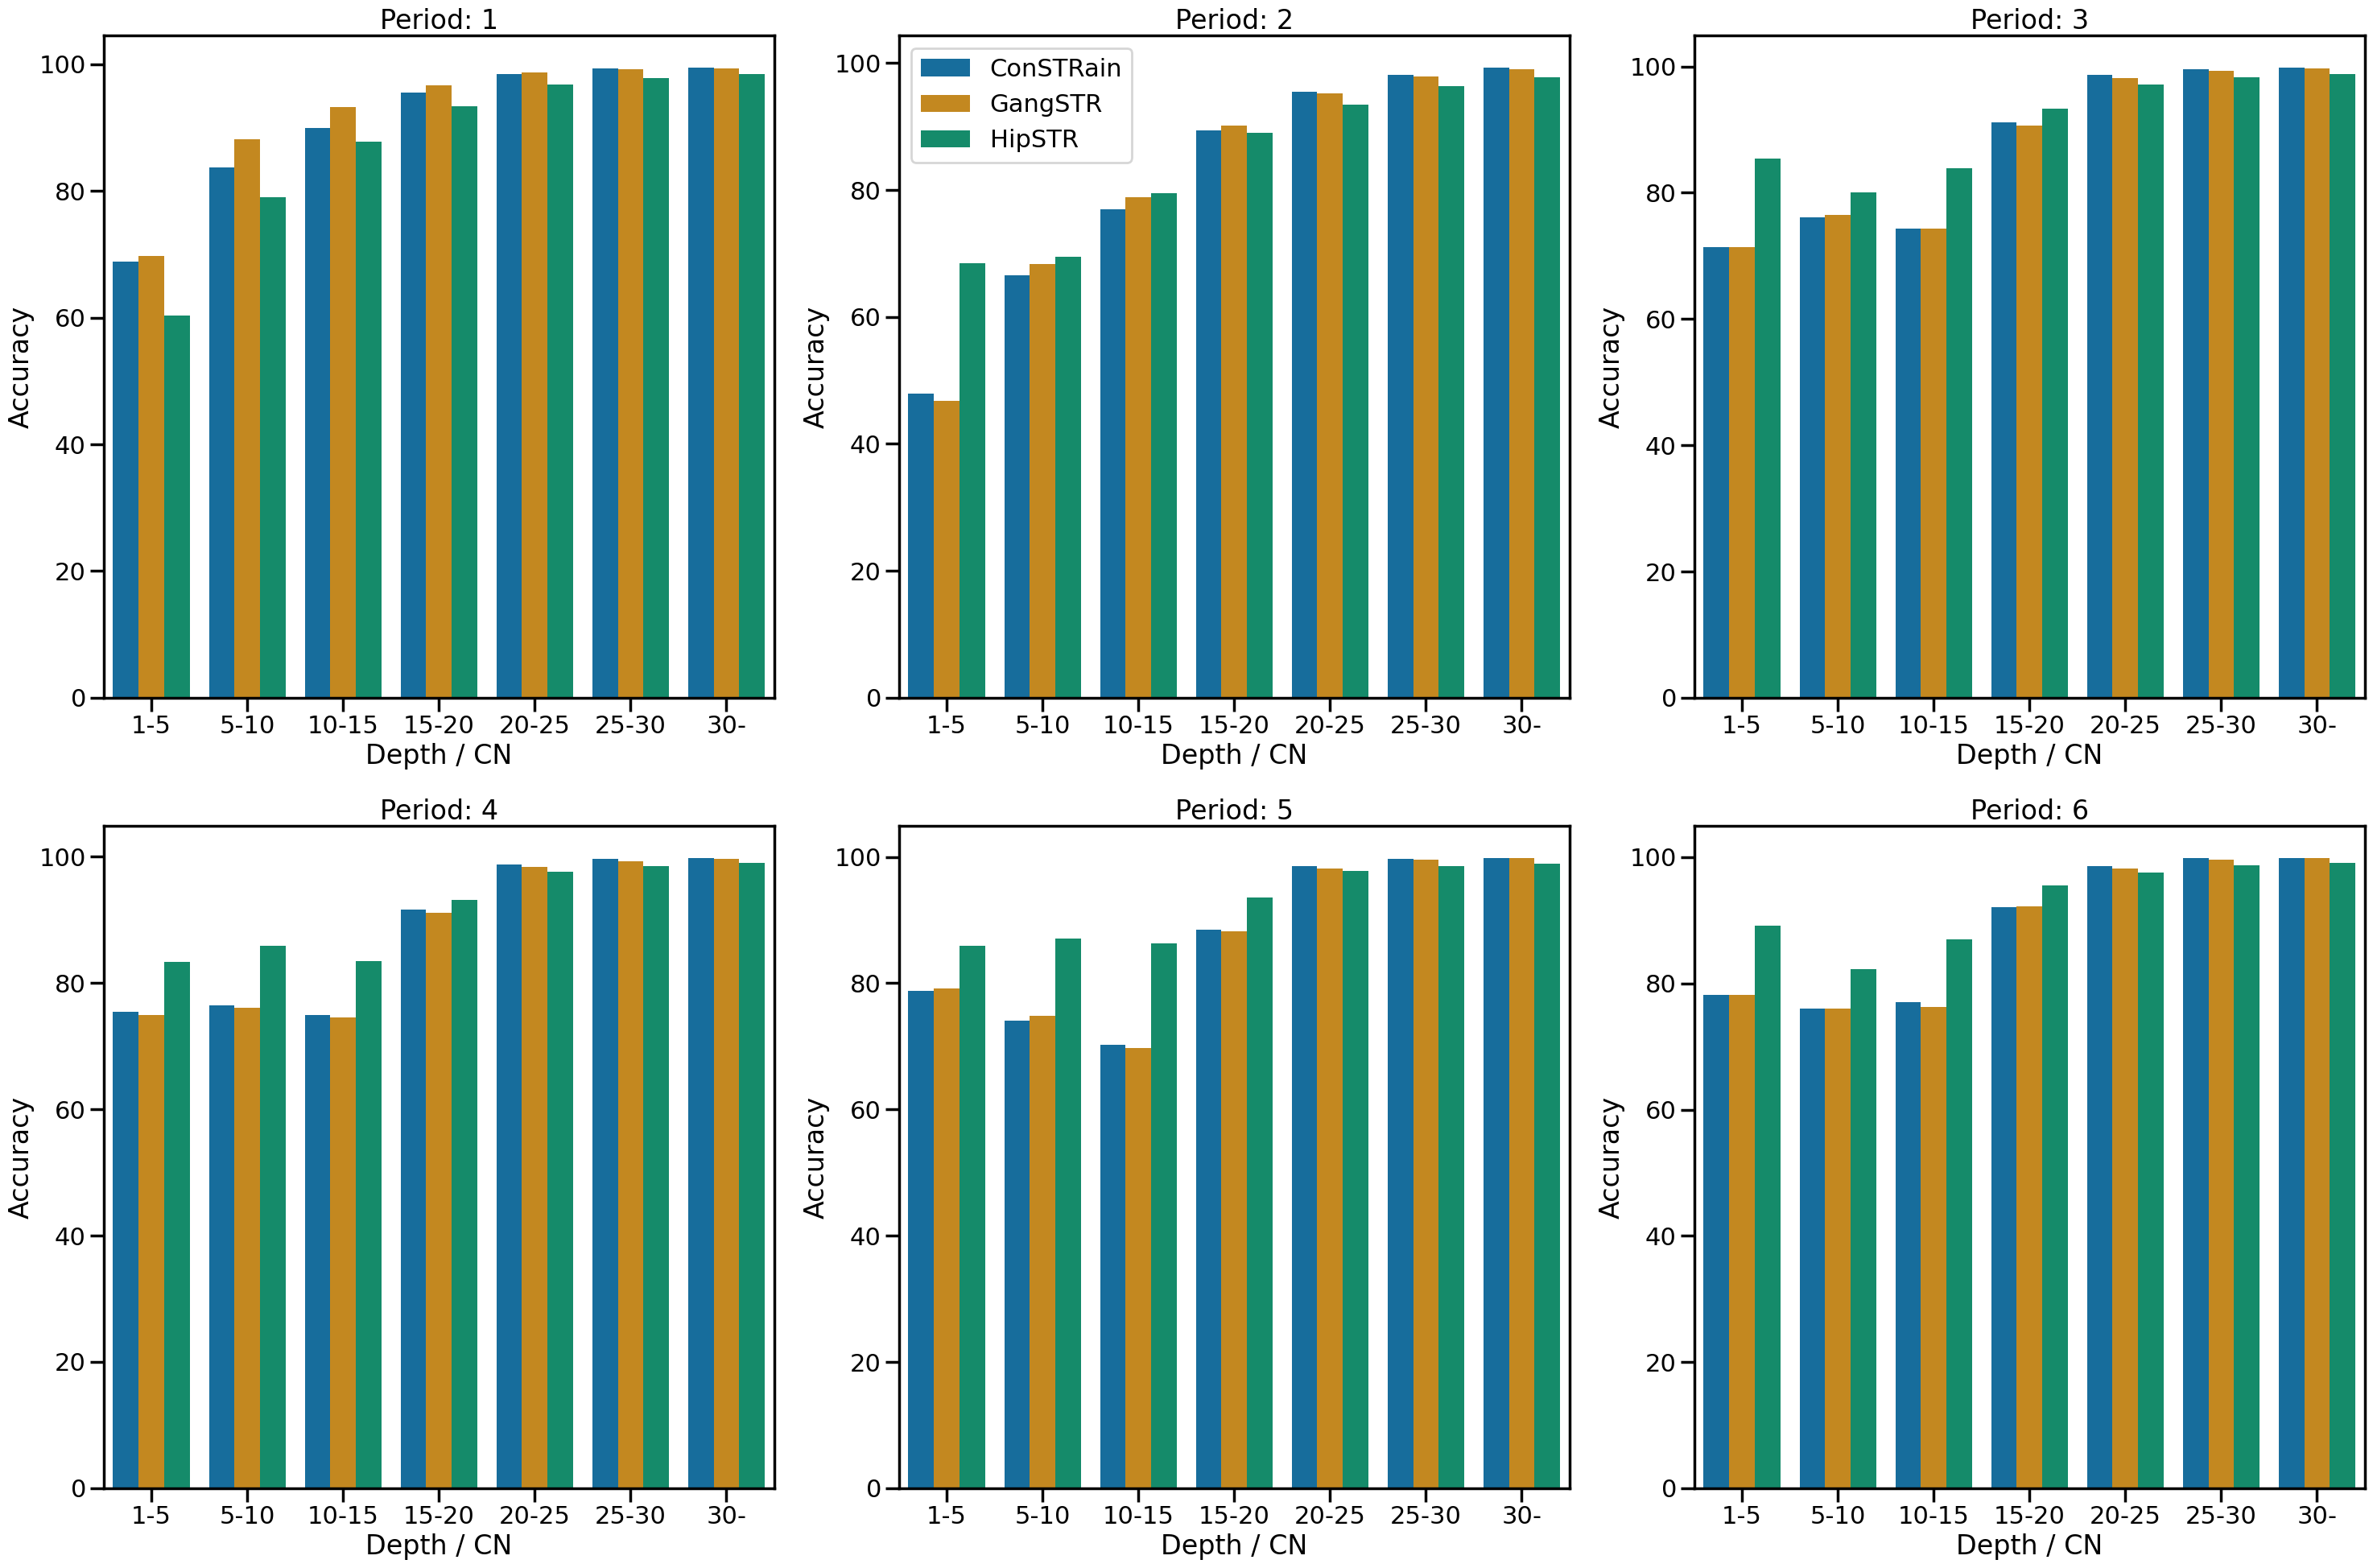

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(30, 20))

for period, ax in zip(range(1, 7), axes.ravel()):
    df_subplot = (df_plot
                  .rename(columns = {"constrain_accuracy": "ConSTRain", "gangstr_accuracy": "GangSTR", "hipstr_accuracy": "HipSTR"})
                  .query(f"period == {period}")[["ConSTRain", "GangSTR", "HipSTR", "depth"]]
                  .melt(id_vars="depth",var_name="approach", value_name="accuracy"))
    
    ax = sns.barplot(
        data=df_subplot,
        x="depth",
        y="accuracy",
        hue="approach",
        palette="colorblind",
        ax = ax,
        legend = period == 2
    )
    if period == 2:
        # ax.get_legend().set(bbox_to_anchor = (1,1), title="")
        ax.get_legend().set(title="")
    ax.set(
        title = f"Period: {period}",
        xlabel = "Depth / CN",
        ylabel = "Accuracy"
    )

plt.tight_layout()

In [50]:
df_plot_density = (
    df_str_calls
        .rename(columns = {"constrain_match": "ConSTRain", "gangstr_match": "GangSTR", "hipstr_match": "HipSTR"})
        .query("period >= 1 and period <= 6")
        .assign(depth = lambda x: x["depth"] / x["copy_number"])[["ConSTRain", "GangSTR", "HipSTR", "period", "depth"]]
)

df_plot_density

,ConSTRain,GangSTR,HipSTR,period,depth
0,True,True,True,3,11.0
1,True,True,True,4,30.0
2,True,True,True,4,21.0
3,True,True,True,3,10.5
4,True,True,True,1,20.0
...,...,...,...,...,...
1221039,True,True,True,5,28.0
1221040,True,True,True,3,23.0
1221041,True,True,True,5,31.0
1221042,True,True,True,1,33.0


In [51]:
from scipy import ndimage

df_plot_smooth = (
    df_plot_density        
        .drop("period", axis=1)
        .melt(id_vars="depth",var_name="approach", value_name="match")
        .groupby(["approach", "depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
)

# df_plot_smooth["smooth"] = np.nan
smooth = []
for name, data in df_plot_smooth.groupby("approach"):
    inner_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
    smooth.append(inner_smooth)
df_plot_smooth["accuracy"] = np.concatenate(smooth)
df_plot_smooth

,approach,depth,accuracy,n_obs
0,ConSTRain,0.5,0.474273,95
1,ConSTRain,1.0,0.496139,258
2,ConSTRain,1.5,0.534653,325
3,ConSTRain,2.0,0.581659,296
4,ConSTRain,2.5,0.629172,331
...,...,...,...,...
796,HipSTR,349.0,0.524604,1
797,HipSTR,356.0,0.478742,1
798,HipSTR,396.5,0.453621,1
799,HipSTR,402.5,0.443795,1


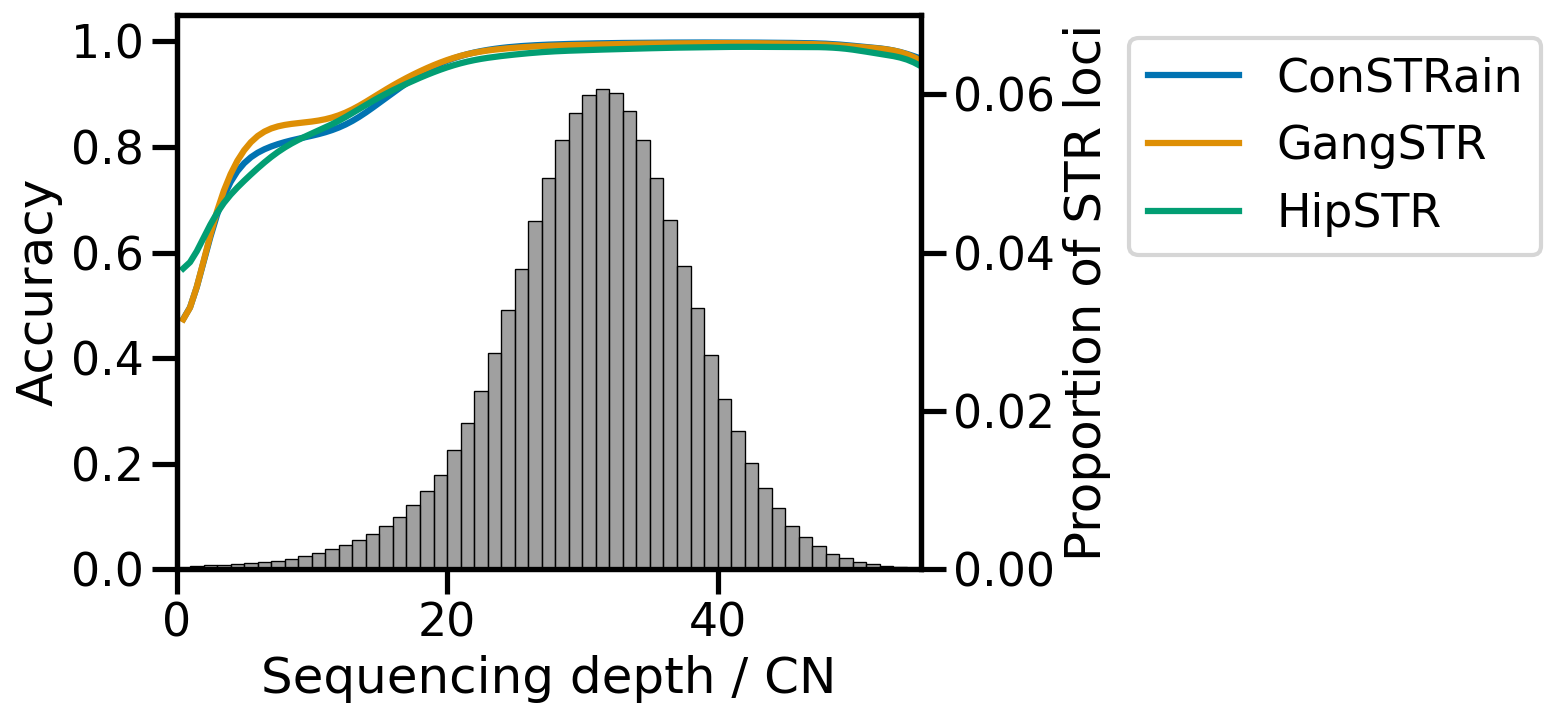

In [53]:
fig = plt.figure(dpi=150)

ax = sns.lineplot(
    df_plot_smooth,
    x = "depth",
    y = "accuracy",
    hue = "approach",
    palette="colorblind"
)

ax.set(
    # title = "GangSTR",
    xlabel = "Sequencing depth / CN",
    ylabel = "Accuracy",
    ylim = (0, 1.05),
    xlim = (0, 55)
)

ax2 = ax.twinx()
ax2 = sns.histplot(
    df_plot_density,
    x = "depth",
    discrete=True,
    stat="proportion",
    color="grey",
    ax=ax2,
)
ax2.set(
    ylabel="Proportion of STR loci",
    ylim=(0, 0.07),
)

ax.get_legend().set(bbox_to_anchor=(1.25, 1), loc="upper left", title="")

plt.show()

In [55]:
df_plot_density

,ConSTRain,GangSTR,HipSTR,period,depth
0,True,True,True,3,11.0
1,True,True,True,4,30.0
2,True,True,True,4,21.0
3,True,True,True,3,10.5
4,True,True,True,1,20.0
...,...,...,...,...,...
1221039,True,True,True,5,28.0
1221040,True,True,True,3,23.0
1221041,True,True,True,5,31.0
1221042,True,True,True,1,33.0


In [56]:
from scipy import ndimage

df_plot_smooth_period = (
    df_plot_density        
        .melt(id_vars=["period", "depth"],var_name="approach", value_name="match")
        .groupby(["approach", "period", "depth"], observed=True, as_index=False).agg(
            accuracy = ("match", lambda x: x.sum() / len(x)), 
            n_obs=("match", "count"))
)

smooth = []
for name, data in df_plot_smooth_period.groupby("approach"):
    inner_smooth = ndimage.gaussian_filter1d(data["accuracy"], 3, mode="reflect")
    smooth.append(inner_smooth)
df_plot_smooth_period["accuracy"] = np.concatenate(smooth)
df_plot_smooth_period

,approach,period,depth,accuracy,n_obs
0,ConSTRain,1,1.0,0.629725,106
1,ConSTRain,1,1.5,0.636812,181
2,ConSTRain,1,2.0,0.650171,164
3,ConSTRain,1,2.5,0.668327,223
4,ConSTRain,1,3.0,0.689410,247
...,...,...,...,...,...
3148,HipSTR,6,108.5,0.996201,1
3149,HipSTR,6,110.5,0.998523,1
3150,HipSTR,6,126.0,0.999486,1
3151,HipSTR,6,140.0,0.999840,1


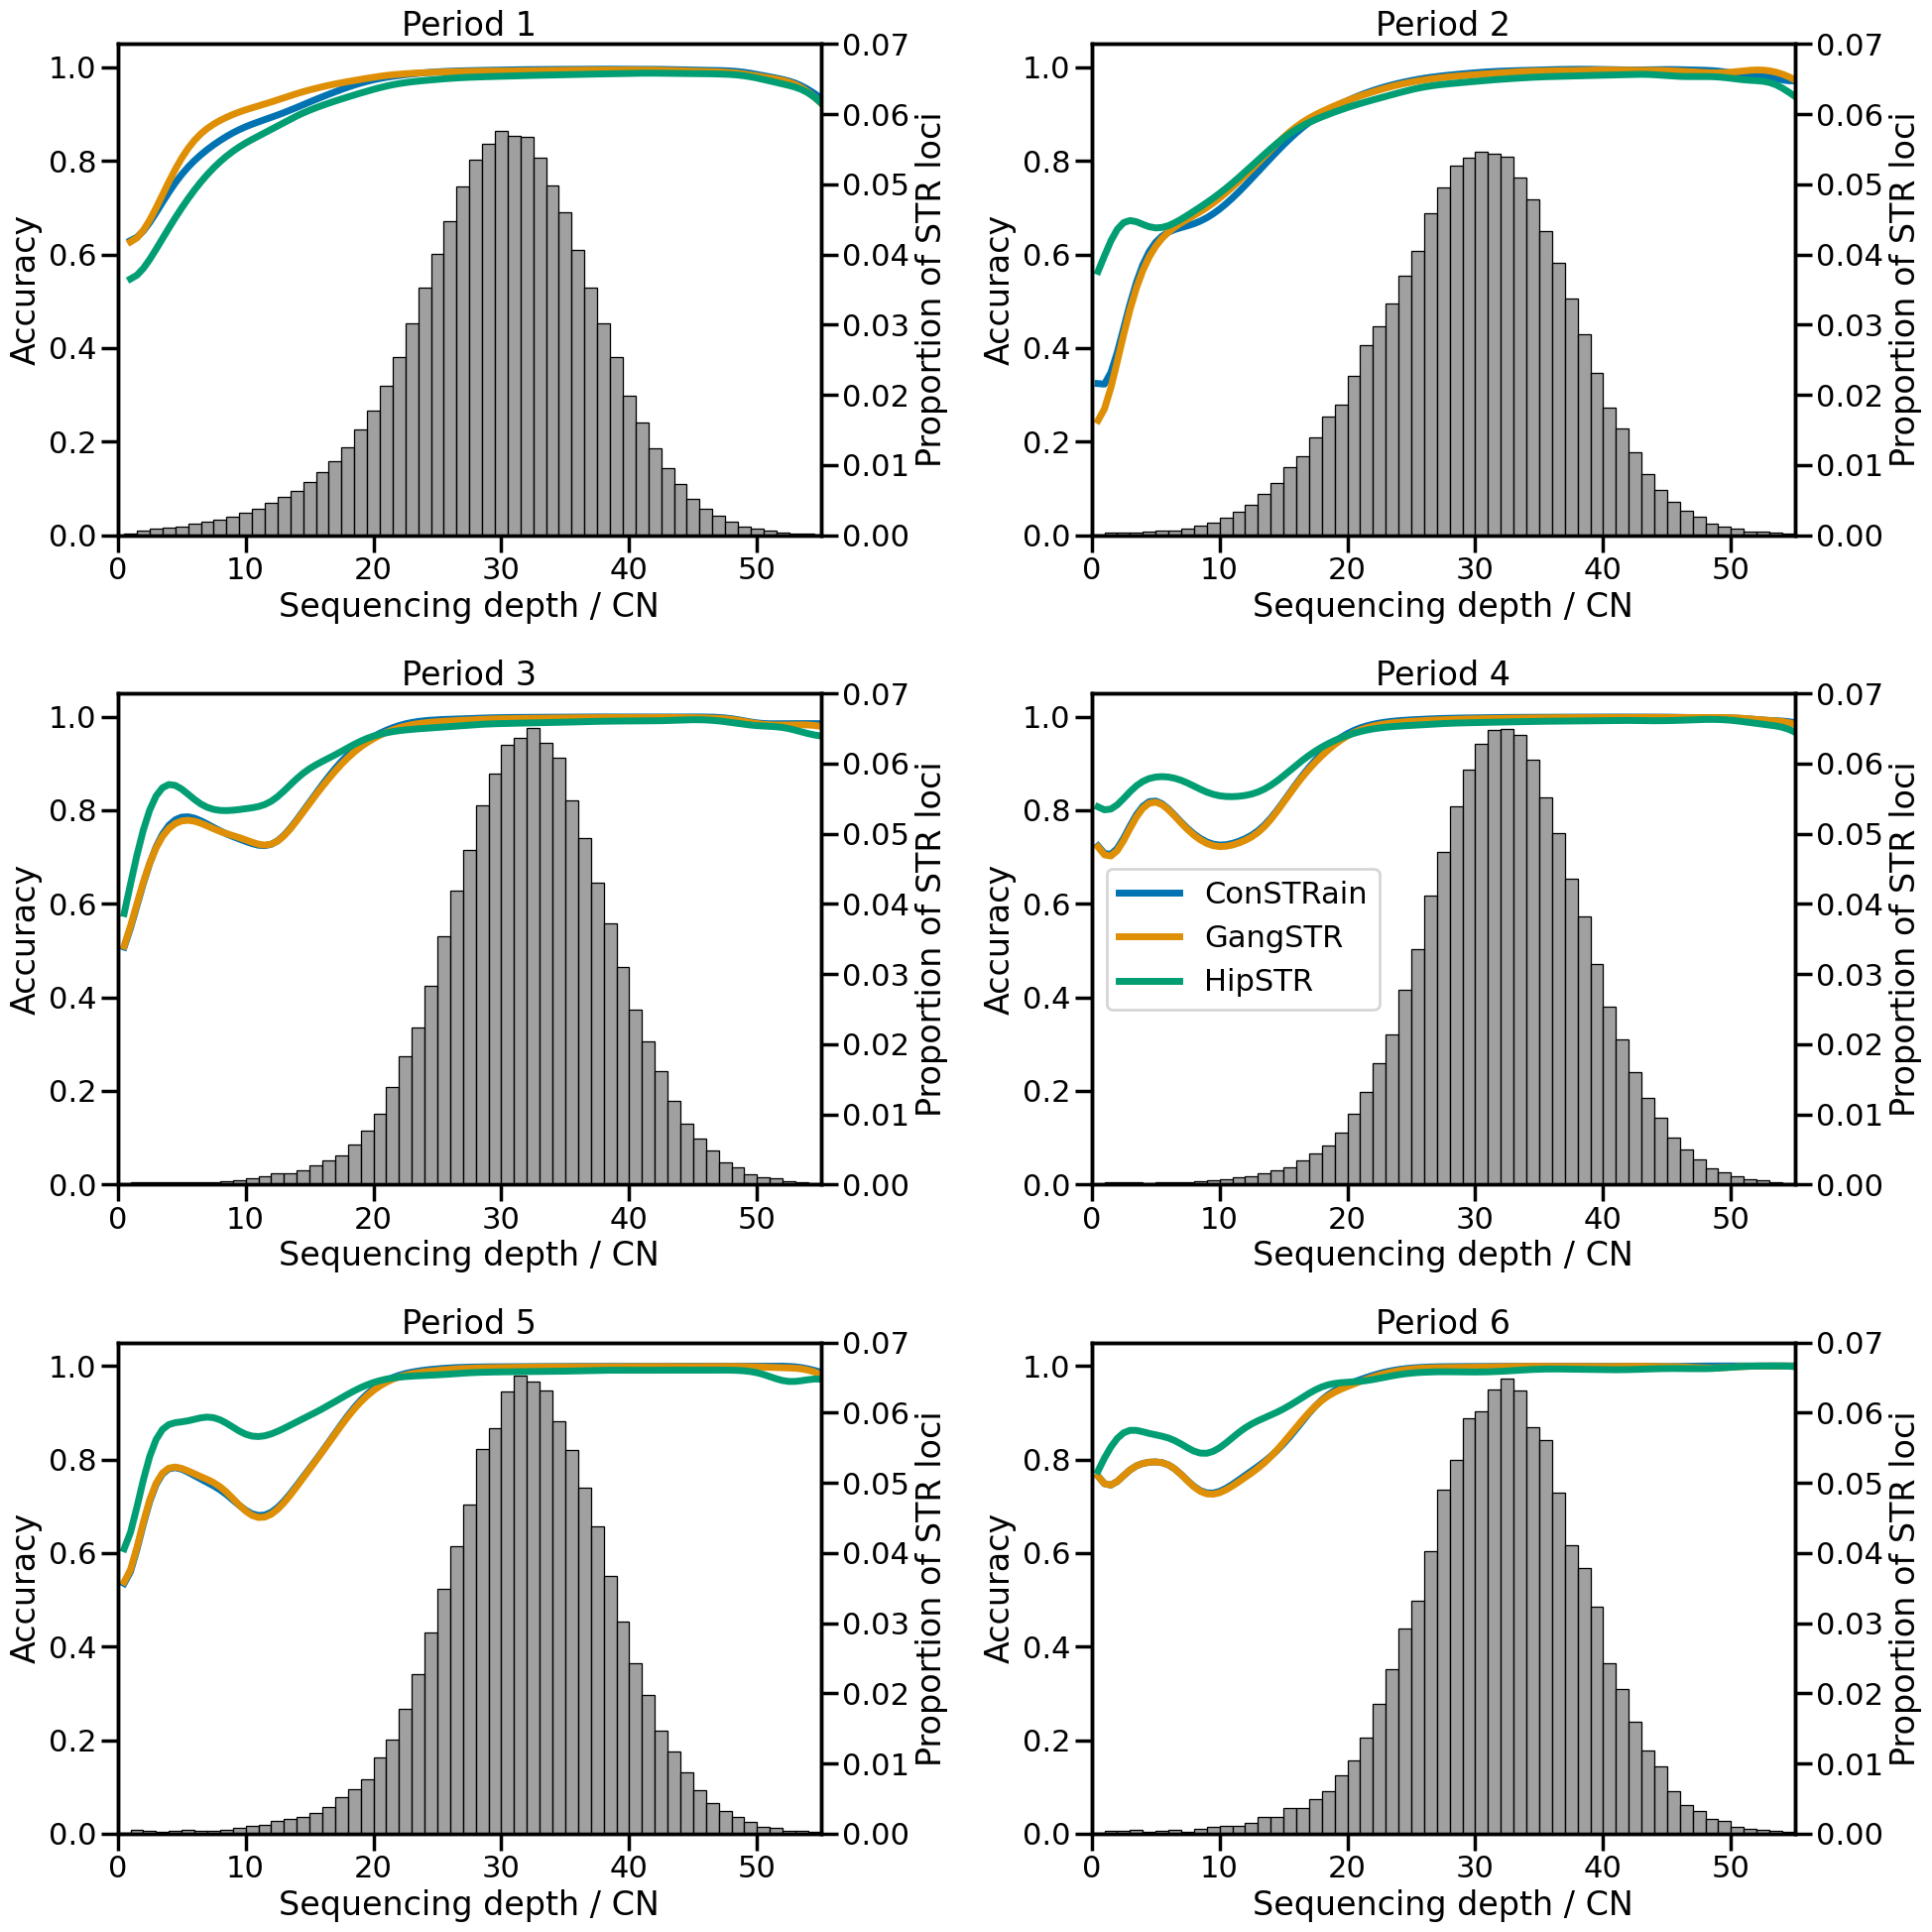

In [62]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20))

for period, ax in zip(range(1, 7), axes.ravel()):
    df_subplot = (df_plot_smooth_period
                  .query(f"period == {period}"))

    add_legend = period == 4
    ax = sns.lineplot(
        df_subplot,
        x = "depth",
        y = "accuracy",
        hue = "approach",
        palette="colorblind",
        linewidth=5,
        ax = ax,
        legend= add_legend
    )

    if add_legend:
        ax.get_legend().set(loc="center left", title=None)
    
    ax.set(
        title = f"Period {period}",
        xlabel = "Sequencing depth / CN",
        ylabel = "Accuracy",
        ylim = (0, 1.05),
        xlim = (0, 55)
    )
    
    ax2 = ax.twinx()
    ax2 = sns.histplot(
        df_plot_density.query(f"period == {period}"),
        x = "depth",
        discrete=True,
        stat="proportion",
        color="grey",
        ax=ax2,
    )
    
    ax2.set(
        ylabel="Proportion of STR loci",
        # ylim=(0, ax2.get_ylim()[1] + 0.01),
        ylim=(0, 0.07),
    )

plt.tight_layout()